In [1]:
import cv2
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.image import resize

In [3]:
import json

def append_to_json(filename, new_data):
    """
    Додає новий запис до JSON файлу.

    Args:
        filename (str): Ім'я файлу.
        new_data (dict): Нові дані для додавання.
    """

    try:
        # Спробувати прочитати існуючий файл
        with open(filename, 'r') as json_file:
            data = json.load(json_file)
    except FileNotFoundError:
        # Якщо файл не існує, створити новий список
        data = []

    # Додати нові дані до списку
    data.append(new_data)

    # Записати оновлені дані у файл
    with open(filename, 'w') as json_file:
        json.dump(data, json_file, indent=4)

In [4]:
import matplotlib.pyplot as plt


def plot_training_history(json_file, model_name):
    """
    Побудова графіків тренувань та валідаційних метрик.
    
    Args:
        json_file (str): Шлях до JSON файлу з історією тренувань.
        model_name (str): Назва моделі для побудови графіків.
    """
    # Завантаження оцінки та історії тренувань з JSON файлу
    with open(json_file, 'r') as f:
        evaluation_results = json.load(f)

    # Знайти потрібну модель за назвою
    history_dict = next((item['history'] for item in evaluation_results if item["model_name"] == model_name), None)

    if history_dict is None:
        print(f"Модель з назвою {model_name} не знайдена у {json_file}")
        return

    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    accuracy_values = history_dict['accuracy']
    val_accuracy_values = history_dict['val_accuracy']

    epochs = range(1, len(accuracy_values) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy_values, 'bo', label='Training acc')
    plt.plot(epochs, val_accuracy_values, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [5]:
# Завантаження CIFAR-10 датасету
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Нормалізація зображень
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Перетворення міток у категоріальний формат (one-hot encoding)
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Перевірка форми даних
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 10)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 10)


In [6]:
labels_map = {0: "Airplane", 
              1: "Automobile", 
              2: "Bird", 
              3: "Cat", 
              4: "Deer", 
              5: "Dog", 
              6: "Frog", 
              7: "Horse", 
              8: "Ship", 
              9: "Truck"}

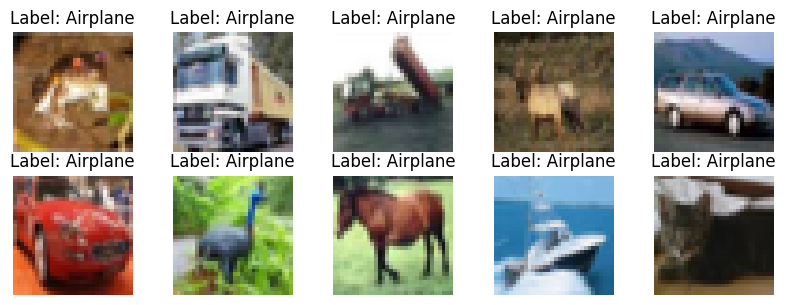

In [7]:
# First 10 images
plt.figure(figsize=(10, 9))
for i in range(0, 10):
    ax = plt.subplot(5, 5, i+1)
    plt.title(f"Label: {labels_map[y_train[i][0]]}")
    plt.imshow(x_train[i], cmap="gray")
    plt.axis("off")

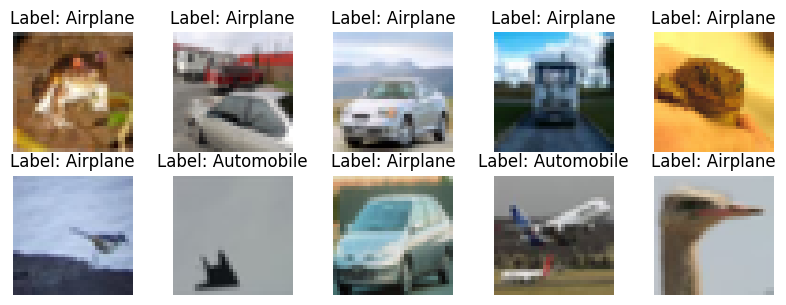

In [8]:
# Last 10 images
plt.figure(figsize=(10, 9))
for i in range(0, 10):
    ax = plt.subplot(5, 5, i+1)
    plt.title(f"Label: {labels_map[y_train[-i][0]]}")
    plt.imshow(x_train[-i], cmap="gray")
    plt.axis("off")

In [ ]:
# Назва моделі
model_name = "Model_2_VGG16"

# Гіперпараметри
img_size = (56, 56)  # Збільшуємо розмір зображень до 56x56
num_classes = 10
batch_size = 128
epochs = 10
rotation_range = 20
width_shift_range = 0.1
height_shift_range = 0.1
shear_range = 0.1
zoom_range = 0.1
horizontal_flip = True
fill_mode = 'nearest'
patience = 5

# Завантаження CIFAR-10 датасету
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Нормалізація
x_train = x_train / 255.0
x_test = x_test / 255.0

# Зміна розмірності зображень до 56x56
x_train = tf.image.resize(x_train, img_size)
x_test = tf.image.resize(x_test, img_size)

# Перевірка формату
print(f"x_train shape after resizing: {x_train.shape}")
print(f"x_test shape after resizing: {x_test.shape}")

# One-hot encode target labels
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_test_encoded = to_categorical(y_test, num_classes=num_classes)

# Створення базової моделі VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
base_model.trainable = True

# Додавання класифікаційної частини
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Компіляція моделі
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Збільшення даних за допомогою ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=rotation_range,
    width_shift_range=width_shift_range,
    height_shift_range=height_shift_range,
    shear_range=shear_range,
    zoom_range=zoom_range,
    horizontal_flip=horizontal_flip,
    fill_mode=fill_mode
)

# EarlyStopping колбек
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=patience,
    restore_best_weights=True
)

# Навчання моделі
history = model.fit(
    datagen.flow(x_train, y_train_encoded, batch_size=batch_size),
    epochs=epochs,
    validation_data=(x_test, y_test_encoded),
    callbacks=[early_stopping]
)

# Оцінка моделі
test_loss, test_acc = model.evaluate(x_test, y_test_encoded)
print(f"Test accuracy: {test_acc}")

# Збереження моделі
model.save('model_2_vgg16.h5')

# Збереження оцінки та історії тренувань у JSON файл
evaluation_results = {
    "model_name": model_name,
    "test_loss": test_loss,
    "test_accuracy": test_acc,
    "history": history.history
}

append_to_json('cifar_model_evaluation.json', evaluation_results)

x_train shape after resizing: (50000, 56, 56, 3)
x_test shape after resizing: (10000, 56, 56, 3)
Epoch 1/10
391/391 [==============================] - 1755s 4s/step - loss: 1.0437 - accuracy: 0.6454 - val_loss: 0.5083 - val_accuracy: 0.8294
Epoch 2/10
391/391 [==============================] - 1718s 4s/step - loss: 0.5461 - accuracy: 0.8220 - val_loss: 0.4823 - val_accuracy: 0.8431
Epoch 3/10
391/391 [==============================] - 1707s 4s/step - loss: 0.4266 - accuracy: 0.8600 - val_loss: 0.3484 - val_accuracy: 0.8813
Epoch 4/10
391/391 [==============================] - 1723s 4s/step - loss: 0.3561 - accuracy: 0.8844 - val_loss: 0.3229 - val_accuracy: 0.8928
Epoch 5/10
391/391 [==============================] - 1698s 4s/step - loss: 0.3105 - accuracy: 0.8970 - val_loss: 0.3074 - val_accuracy: 0.8991
Epoch 6/10
391/391 [==============================] - 1710s 4s/step - loss: 0.2695 - accuracy: 0.9111 - val_loss: 0.2608 - val_accuracy: 0.9110
Epoch 7/10
391/391 [===================

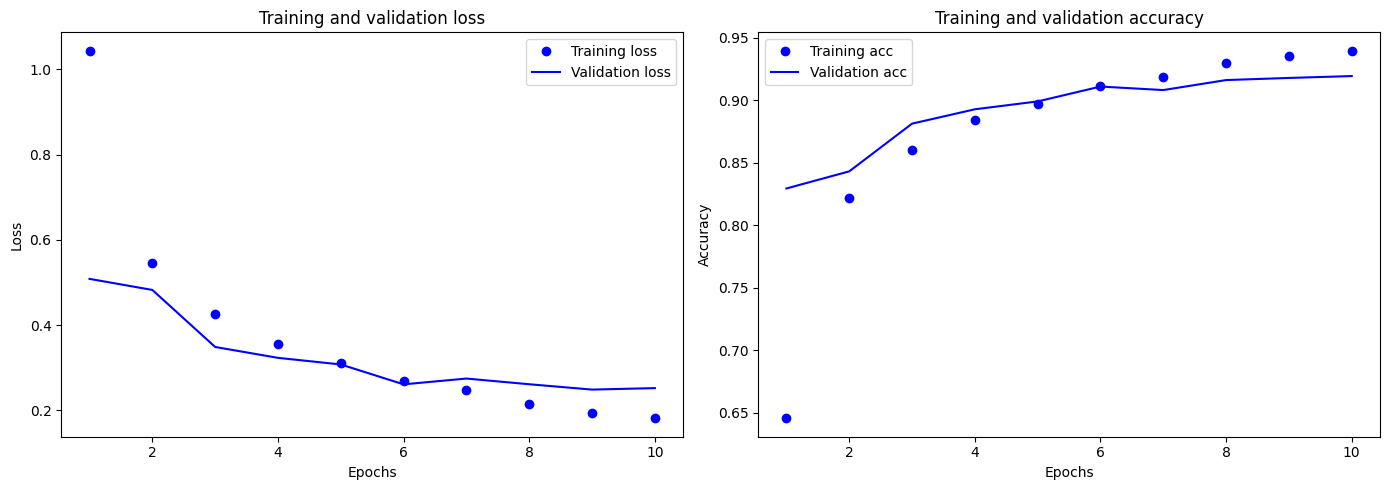

In [93]:
plot_training_history('cifar_model_evaluation.json', 'Model_2_VGG16')

## Матриця невідповідностей

313/313 [==============================] - 42s 131ms/step


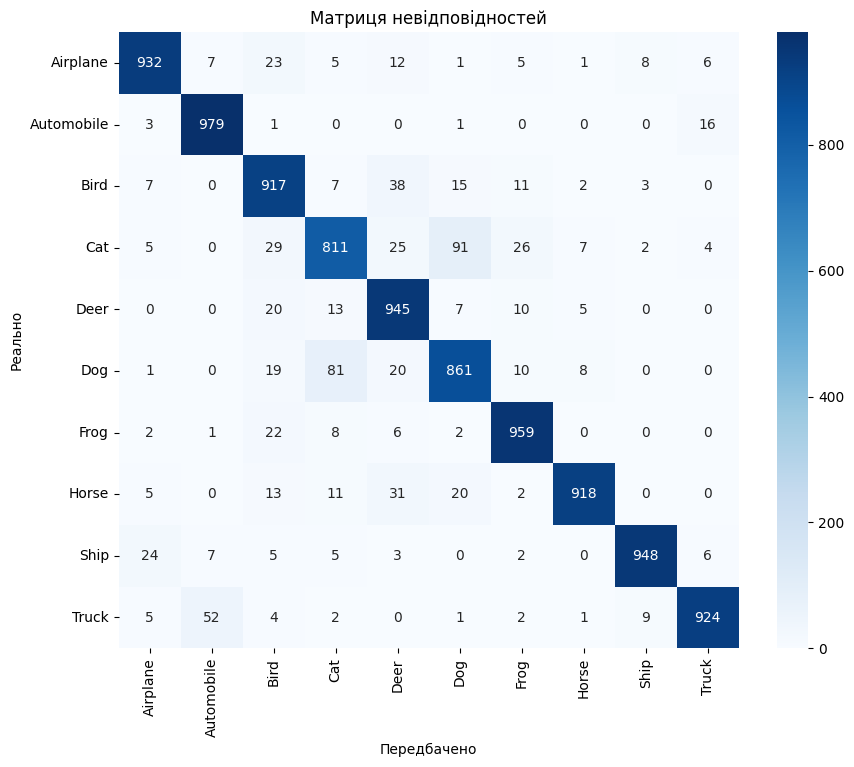

In [96]:
# Завантажуємо датасет CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Нормалізуємо дані
x_test = x_test.astype('float32') / 255.0

# Змінюємо розмір зображень до (56, 56, 3)
x_test_resized = resize(x_test, [56, 56])

# Завантажуємо модель
model = load_model('model_2_vgg16.h5')

# Робимо передбачення
y_pred = model.predict(x_test_resized)
y_pred_classes = np.argmax(y_pred, axis=1)

# Перетворюємо y_test на одновимірний масив
y_true = y_test.flatten()

# Обчислюємо матрицю невідповідностей
cm = confusion_matrix(y_true, y_pred_classes)

# Створюємо список міток на основі словника
class_labels = [labels_map[i] for i in range(10)]

# Візуалізуємо матрицю невідповідностей
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=class_labels, yticklabels=class_labels)
plt.title('Матриця невідповідностей')
plt.xlabel('Передбачено')
plt.ylabel('Реально')
plt.show()


## Звіт про класифікацію

In [100]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1000
           1       0.94      0.98      0.96      1000
           2       0.87      0.92      0.89      1000
           3       0.86      0.81      0.83      1000
           4       0.88      0.94      0.91      1000
           5       0.86      0.86      0.86      1000
           6       0.93      0.96      0.95      1000
           7       0.97      0.92      0.95      1000
           8       0.98      0.95      0.96      1000
           9       0.97      0.92      0.94      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



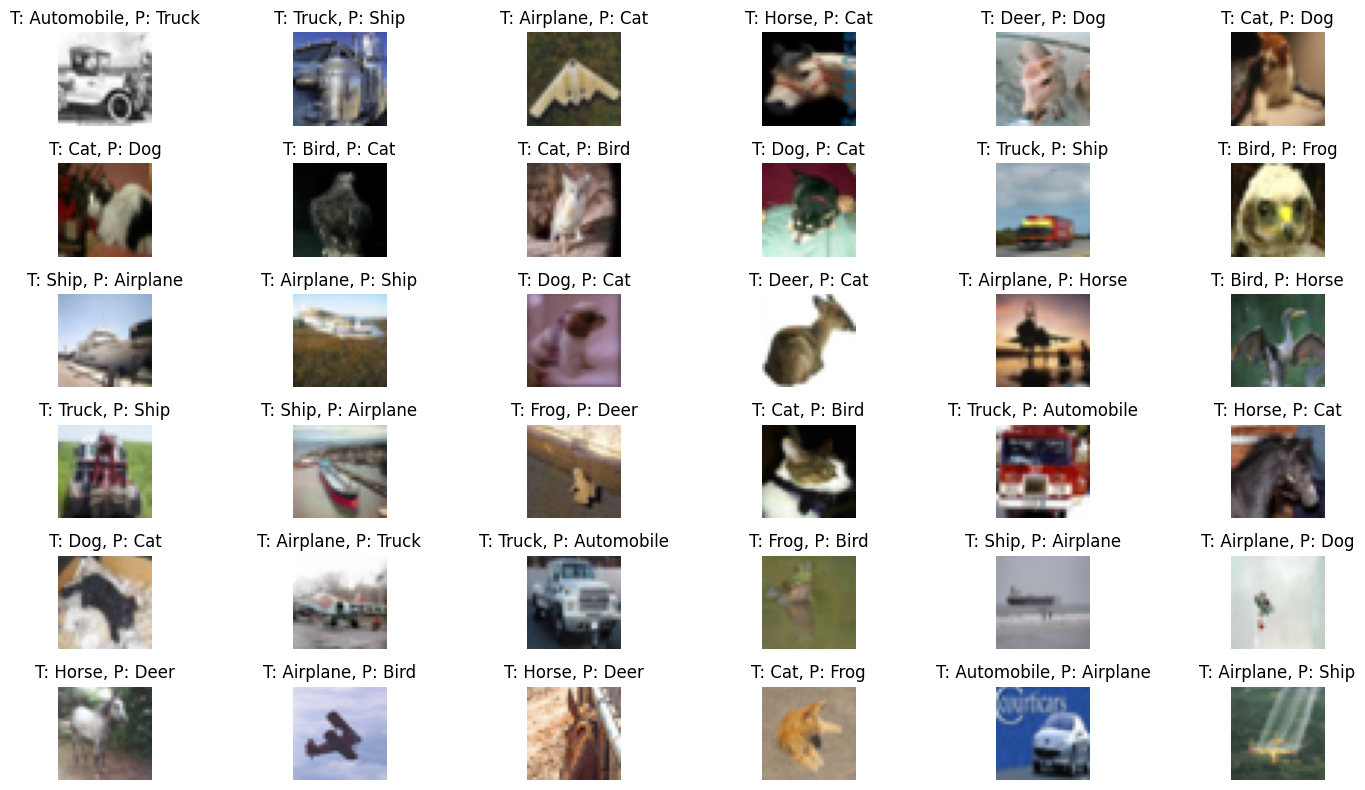

In [106]:
# Індекс неправильно класифікованих зображень
incorrect = np.where(y_pred_classes != y_test.flatten())[0]
num_incorrect = len(incorrect)

# Візуалізуємо перші 36 неправильно класифікованих зображень
plt.figure(figsize=(15, 8))
for i in range(min(num_incorrect, 36)):  # Показуємо перші 36 неправильно класифікованих прикладів
    idx = incorrect[i]
    plt.subplot(6, 6, i + 1)
    plt.imshow(x_test[idx], cmap='gray')
    true_label = labels_map[y_test[idx][0]]
    pred_label = labels_map[y_pred_classes[idx]]
    plt.title(f"T: {true_label}, P: {pred_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

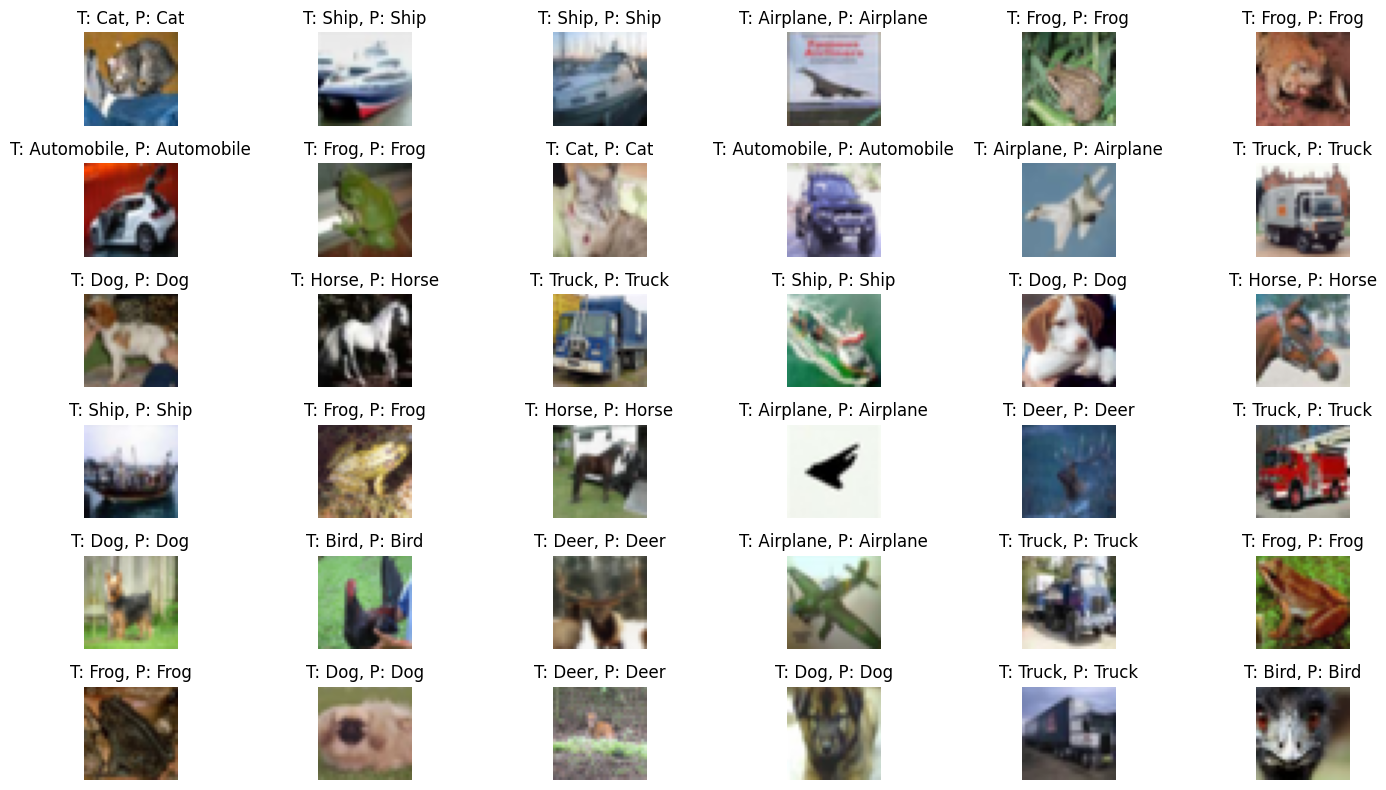

In [105]:
# Індекс правильно класифікованих зображень
correct = np.where(y_pred_classes == y_test.flatten())[0]
num_correct = len(correct)

# Візуалізуємо перші 36 правильно класифікованих зображень
plt.figure(figsize=(15, 8))
for i in range(min(num_correct, 36)):  # Показуємо перші 36 правильно класифікованих прикладів
    idx = correct[i]
    plt.subplot(6, 6, i + 1)
    plt.imshow(x_test[idx], cmap='gray')
    true_label = labels_map[y_test[idx][0]]
    pred_label = labels_map[y_pred_classes[idx]]
    plt.title(f"T: {true_label}, P: {pred_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## Fine tuning

In [3]:
# Завантаження збереженої моделі
saved_model = load_model('model_2_vgg16.h5')

saved_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 56, 56, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 56, 56, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 56, 56, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 28, 28, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 28, 28, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 28, 28, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 14, 14, 128)       0   

In [9]:
# Назва моделі
model_name = "Model_2_VGG16_fine_tuning"

# Гіперпараметри
img_size = (56, 56)
num_classes = 10
batch_size = 256
epochs = 8
rotation_range = 20
width_shift_range = 0.1
height_shift_range = 0.1
shear_range = 0.1
zoom_range = 0.1
horizontal_flip = True
fill_mode = 'nearest'
patience = 5

# Завантаження CIFAR-10 датасету
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Нормалізація
x_train = x_train / 255.0
x_test = x_test / 255.0

# Зміна розмірності зображень до 56x56
x_train = tf.image.resize(x_train, img_size)
x_test = tf.image.resize(x_test, img_size)

# One-hot encode target labels
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_test_encoded = to_categorical(y_test, num_classes=num_classes)

# Збільшення даних за допомогою ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=rotation_range,
    width_shift_range=width_shift_range,
    height_shift_range=height_shift_range,
    shear_range=shear_range,
    zoom_range=zoom_range,
    horizontal_flip=horizontal_flip,
    fill_mode=fill_mode
)

# Завантаження збереженої моделі
saved_model = load_model('model_2_vgg16.h5')

# Витягуємо всі шари базової моделі VGG16 до шару block5_pool, щоб розморозити верхні шари для донавчання
base_model = Model(inputs=saved_model.input, outputs=saved_model.get_layer('block5_pool').output)

# Розморожування block4 і block5
for layer in base_model.layers:
    if 'block4' in layer.name or 'block5' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

# Створення нової моделі з базовою моделлю та новими шарами
x = base_model.output
x = Flatten()(x)  # Той самий Flatten, що був у моделі
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Компіляція моделі з новими параметрами
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Дообучення моделі
history_finetune = model.fit(
    datagen.flow(x_train, y_train_encoded, batch_size=batch_size),
    epochs=epochs,
    validation_data=(x_test, y_test_encoded),
    callbacks=[EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)]
)

# Оцінка моделі
test_loss, test_acc = model.evaluate(x_test, y_test_encoded)
print(f"Test accuracy after fine-tuning: {test_acc}")

# Збереження дообученої моделі
model.save('model_2_finetuned.h5')

# Збереження оцінки та історії тренувань у JSON файл
evaluation_results = {
    "model_name": model_name,
    "test_loss": test_loss,
    "test_accuracy": test_acc,
    "history": history_finetune.history
}

append_to_json('cifar_model_evaluation.json', evaluation_results)


Epoch 1/8
196/196 [==============================] - 1049s 5s/step - loss: 0.8950 - accuracy: 0.7148 - val_loss: 0.2844 - val_accuracy: 0.9116
Epoch 2/8
196/196 [==============================] - 1051s 5s/step - loss: 0.1454 - accuracy: 0.9527 - val_loss: 0.2269 - val_accuracy: 0.9300
Epoch 3/8
196/196 [==============================] - 1056s 5s/step - loss: 0.1034 - accuracy: 0.9659 - val_loss: 0.2152 - val_accuracy: 0.9328
Epoch 4/8
196/196 [==============================] - 1054s 5s/step - loss: 0.0900 - accuracy: 0.9694 - val_loss: 0.2157 - val_accuracy: 0.9344
Epoch 5/8
196/196 [==============================] - 1057s 5s/step - loss: 0.0842 - accuracy: 0.9728 - val_loss: 0.2085 - val_accuracy: 0.9376
Epoch 6/8
196/196 [==============================] - 1066s 5s/step - loss: 0.0757 - accuracy: 0.9750 - val_loss: 0.2113 - val_accuracy: 0.9368
Epoch 7/8
196/196 [==============================] - 1056s 5s/step - loss: 0.0681 - accuracy: 0.9775 - val_loss: 0.2121 - val_accuracy: 0.9376

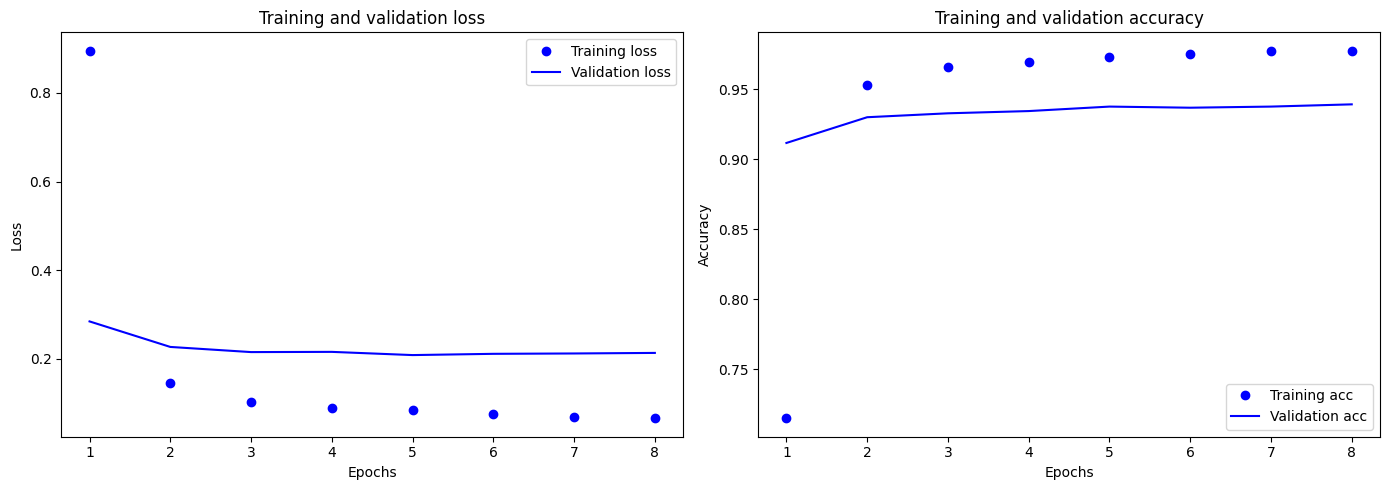

In [10]:
plot_training_history('cifar_model_evaluation.json', 'Model_2_VGG16_fine_tuning')

313/313 [==============================] - 38s 122ms/step


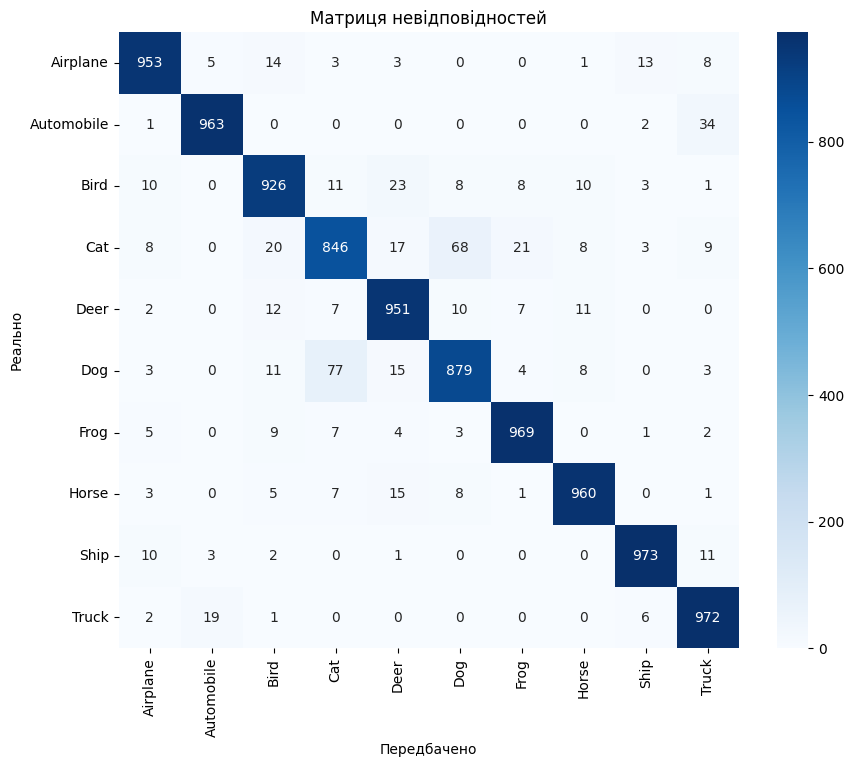

In [11]:
# Завантажуємо датасет CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Нормалізуємо дані
x_test = x_test.astype('float32') / 255.0

# Змінюємо розмір зображень до (56, 56, 3)
x_test_resized = resize(x_test, [56, 56])

# Завантажуємо модель
model = load_model('model_2_finetuned.h5')

# Робимо передбачення
y_pred = model.predict(x_test_resized)
y_pred_classes = np.argmax(y_pred, axis=1)

# Перетворюємо y_test на одновимірний масив
y_true = y_test.flatten()

# Обчислюємо матрицю невідповідностей
cm = confusion_matrix(y_true, y_pred_classes)

# Створюємо список міток на основі словника
class_labels = [labels_map[i] for i in range(10)]

# Візуалізуємо матрицю невідповідностей
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=class_labels, yticklabels=class_labels)
plt.title('Матриця невідповідностей')
plt.xlabel('Передбачено')
plt.ylabel('Реально')
plt.show()

In [12]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1000
           1       0.97      0.96      0.97      1000
           2       0.93      0.93      0.93      1000
           3       0.88      0.85      0.86      1000
           4       0.92      0.95      0.94      1000
           5       0.90      0.88      0.89      1000
           6       0.96      0.97      0.96      1000
           7       0.96      0.96      0.96      1000
           8       0.97      0.97      0.97      1000
           9       0.93      0.97      0.95      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



### Порівняння моделей за точністю

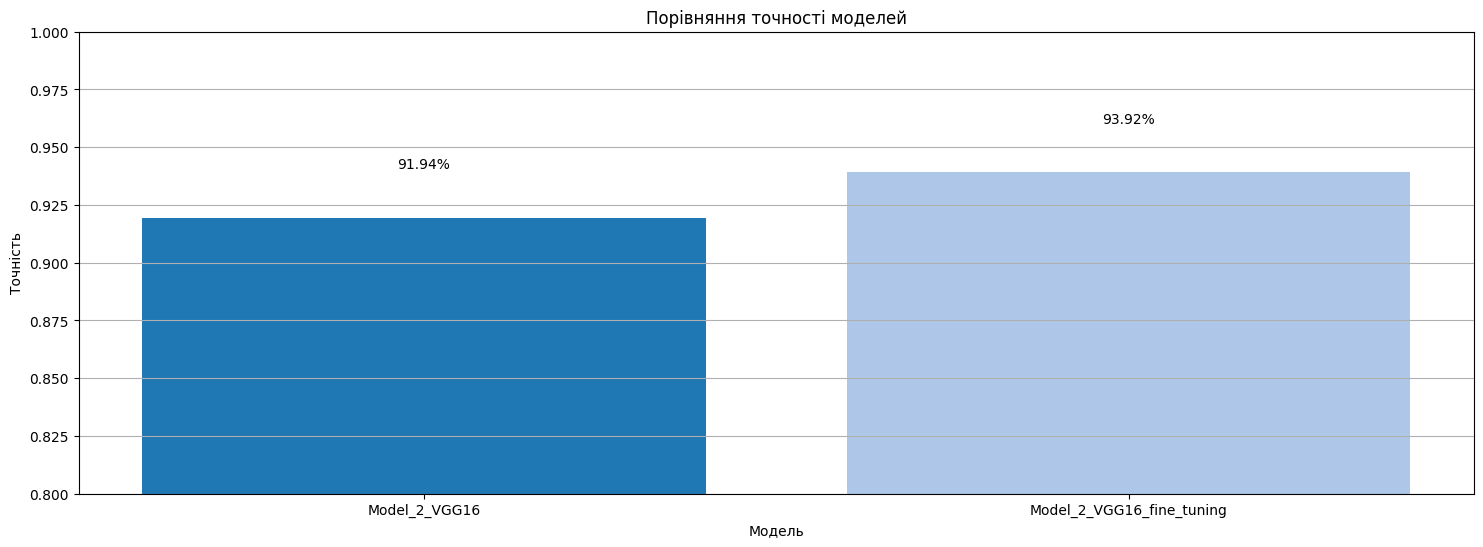

In [14]:
import json
import matplotlib.pyplot as plt

# Завантаження даних з JSON файлу
with open('cifar_model_evaluation.json', 'r') as jsonfile:
    data = json.load(jsonfile)

# Екстракція назв моделей та точності
model_names = [item['model_name'] for item in data]
accuracies = [item['test_accuracy'] for item in data]

# Створення діаграми
plt.figure(figsize=(18, 6))
colors = range(len(model_names))
bars = plt.bar(model_names, accuracies, color=plt.cm.tab20(colors))

# Додавання відсотків над стовпчиками
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval*100:.2f}%', ha='center', va='bottom')

# Налаштування діаграми
plt.xlabel('Модель')
plt.ylabel('Точність')
plt.title('Порівняння точності моделей')
plt.ylim(0.8, 1)
plt.grid(axis='y')

plt.show()